#### Import data set

#### Cleaning, lemmatizing, and removing stop words

In [1]:
import pickle
import datatable as dt
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
%matplotlib inline

with open('cleaned reviews.pkl', 'rb') as f:
    reviews = pickle.load(f)
df = dt.fread('tripadvisor_hotel_reviews.csv').to_pandas()
df.columns = df.columns.str.lower()
df['review'] = reviews
df['rating'] = df['rating'].astype(CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True))
# Add a column length of review
df['review_length'] = df['review'].map(len)

In [2]:
def not_outliers(data, threshold=3):
    '''Returns a list of boolean values indicating if a datum is not an outlier'''
    mean = np.mean(data)
    std = np.std(data)
    return [(datum - mean) / std <= abs(threshold) for datum in data]

In [3]:
length_not_outliers = not_outliers(df.loc[:, 'review_length'])

[Text(0.5, 1.0, 'Review length without outliers')]

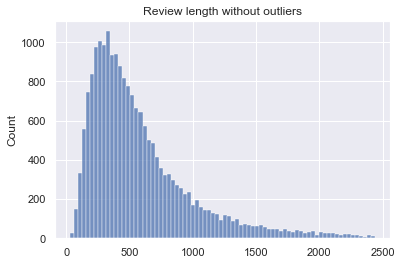

In [4]:
sb.set_theme(style='darkgrid')
sb.histplot(df[length_not_outliers]['review_length'].values).set(title='Review length without outliers')

[Text(0.5, 1.0, 'Rating counts')]

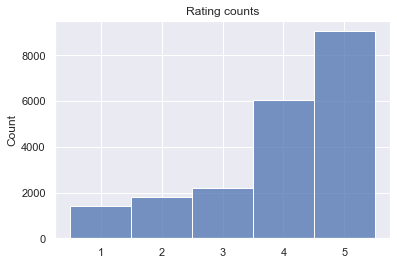

In [5]:
sb.set_theme(style='darkgrid')
sb.histplot(df['rating'].values).set(title='Rating counts')

We can see the pattern that those who are more satisfied are more likely to give reviews.Also, the data set is not balanced among ratings.

#### Get ngrams tokens

In [6]:
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter


def get_most_commons(text_array, n_gram=1):
    text = ''.join(text_array)
    tokens = nltk.word_tokenize(text)
    n_grams = ngrams(tokens, n_gram)
    counter = Counter(n_grams).most_common(20)
    return [(' '.join(i[0]), i[1]) for i in counter]

In [7]:
uni_most_commons = get_most_commons(reviews)
bi_most_commons = get_most_commons(reviews, 2)
tri_most_commons = get_most_commons(reviews, 3)

In [8]:
def to_df(c, col1, col2):
    return pd.DataFrame(data=c, columns=[col1, col2])


df_uni = to_df(uni_most_commons, 'token', 'frequency')
df_bi = to_df(bi_most_commons, 'token', 'frequency')
df_tri = to_df(tri_most_commons, 'token', 'frequency')

# Visualization

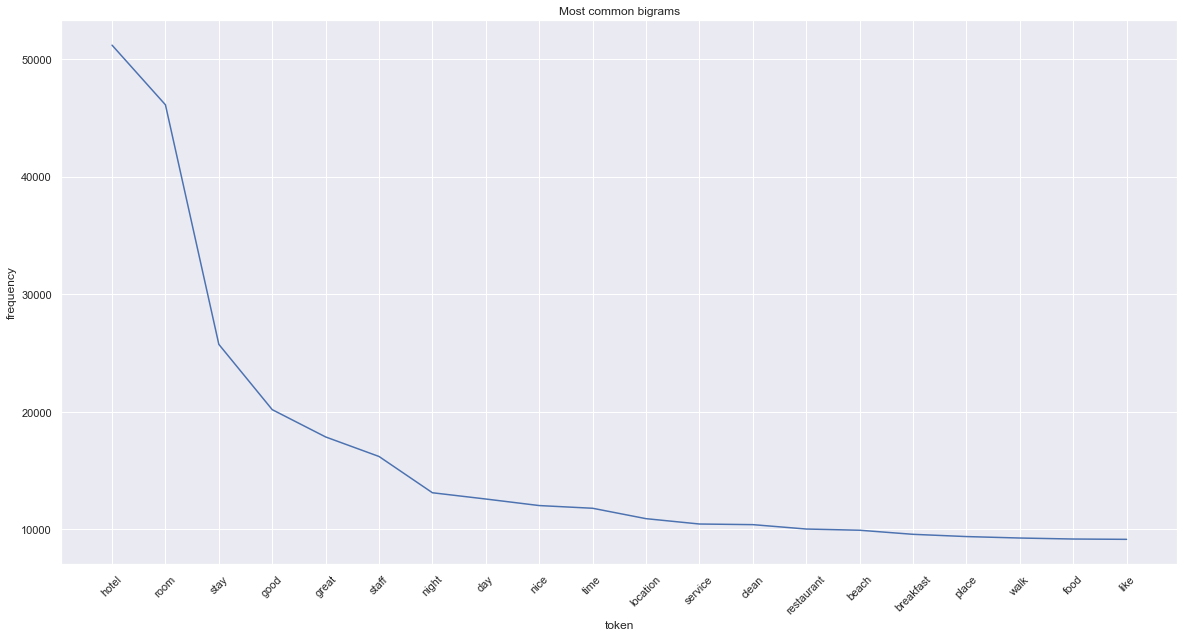

In [9]:
sb.set(rc={"figure.figsize": (20, 10)})
sb.lineplot(data=df_uni, x='token', y='frequency').set(title='Most common bigrams')
plt.xticks(rotation=45);

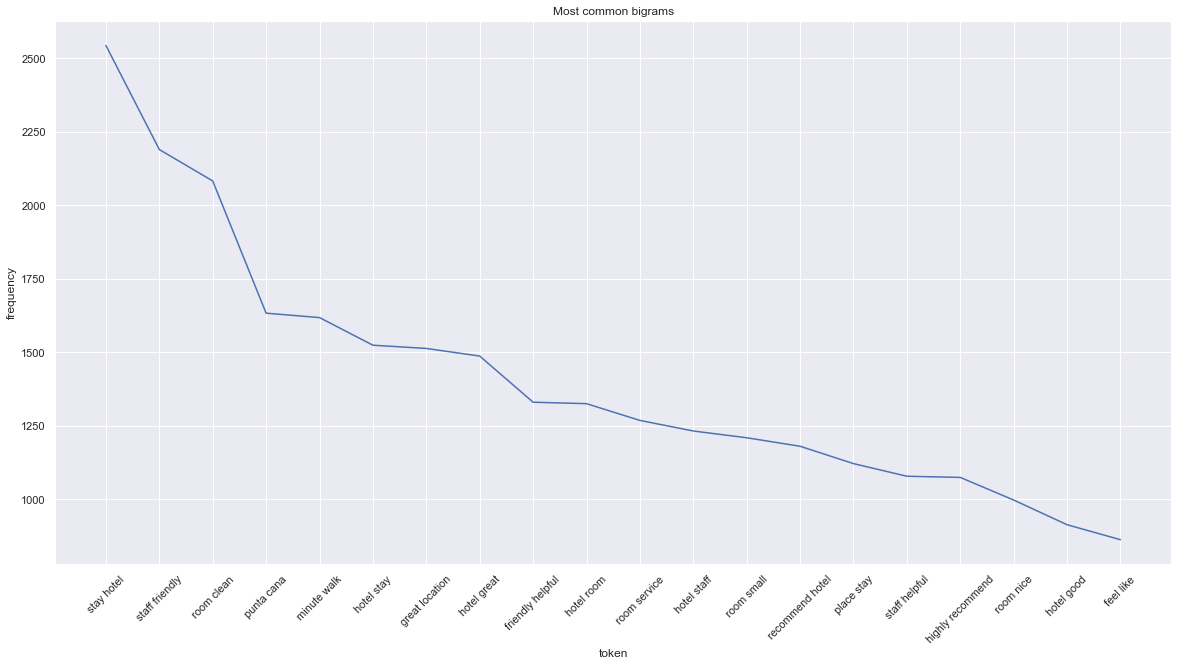

In [10]:
sb.lineplot(data=df_bi, x='token', y='frequency').set(title='Most common bigrams')
plt.xticks(rotation=45);

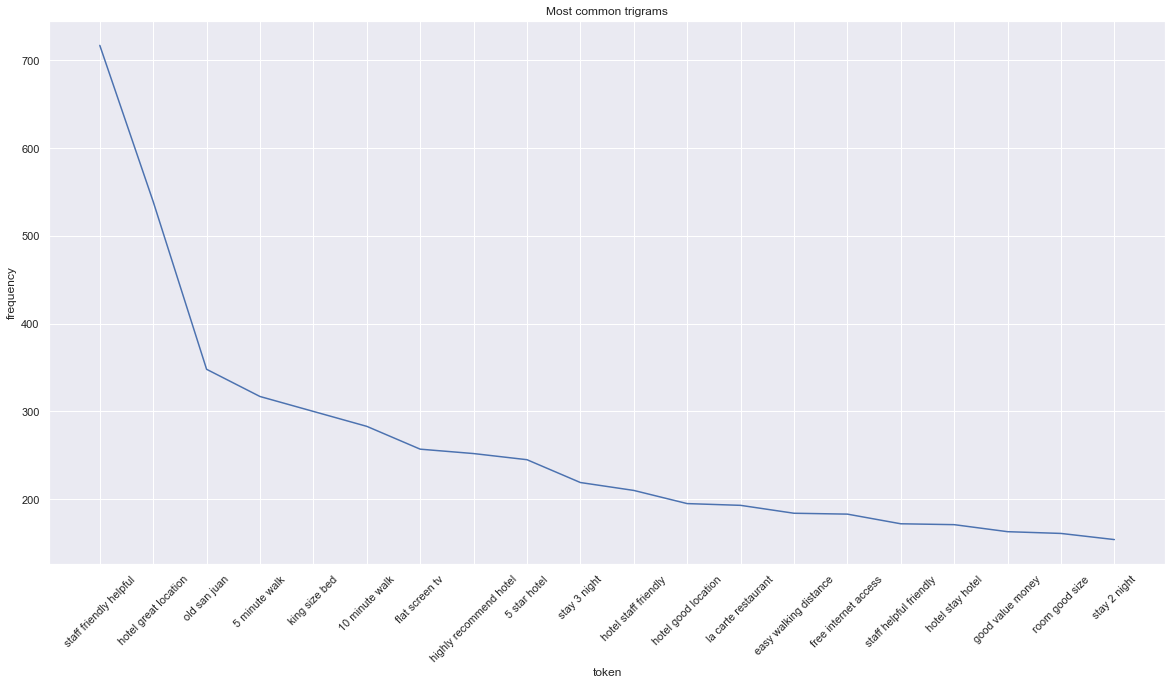

In [11]:
sb.lineplot(data=df_tri, x='token', y='frequency').set(title='Most common trigrams')
plt.xticks(rotation=45);

In [12]:
# Reference https://www.vagabondjourney.com/a-5-step-criteria-for-selecting-hotel-rooms/
criteria = 'location security price quality ambiance'

In [13]:
import spacy


# https://ashutoshtripathi.com/2020/09/04/word2vec-and-semantic-similarity-using-spacy-nlp-spacy-series-part-7/
def extract_text(t: list):
    '''Extracts a joined text from a list of tuples'''
    return ' '.join(i[0] for i in t)


def criteria_ratios(tokens, criteria):
    '''Return a list of percentage of criteria based on the frequency of words in tokens'''
    nlp = spacy.load('en_core_web_md')
    criteria_ratio = [0] * len(criteria.split())
    tokens = nlp(tokens)
    criteria_tokens = nlp(criteria)
    for i, criterion in enumerate(criteria_tokens):
        for token in tokens:
            criteria_ratio[i] += token.similarity(criterion)
    # Get percentage
    sum_ = sum(criteria_ratio)
    for i, _ in enumerate(criteria_ratio):
        criteria_ratio[i] = round(criteria_ratio[i] / sum_ * 100, 2)
    return sorted(zip(criteria.split(), criteria_ratio), key=lambda x: x[1], reverse=True)

In [14]:
uni_ratios = to_df(criteria_ratios(extract_text(uni_most_commons), criteria), 'criterion', 'percentage')
bi_ratios = to_df(criteria_ratios(extract_text(bi_most_commons), criteria), 'criterion', 'percentage')
tri_ratios = to_df(criteria_ratios(extract_text(tri_most_commons), criteria), 'criterion', 'percentage')

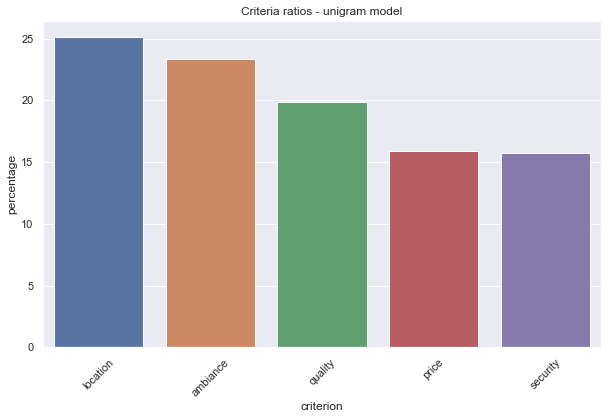

In [15]:
sb.set(rc={"figure.figsize": (10, 6)})
sb.barplot(data=uni_ratios, x='criterion', y='percentage').set(title='Criteria ratios - unigram model')
plt.xticks(rotation=45);

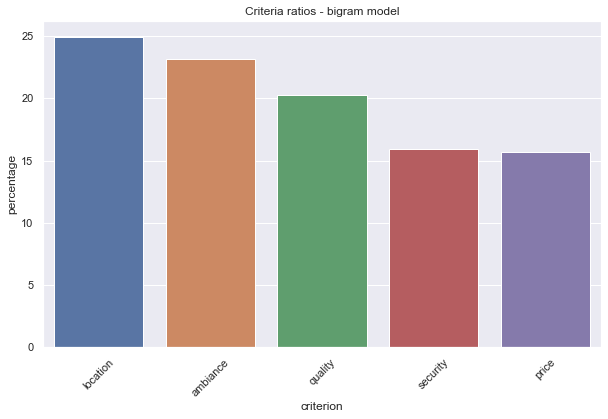

In [16]:
sb.barplot(data=bi_ratios, x='criterion', y='percentage').set(title='Criteria ratios - bigram model')
plt.xticks(rotation=45);

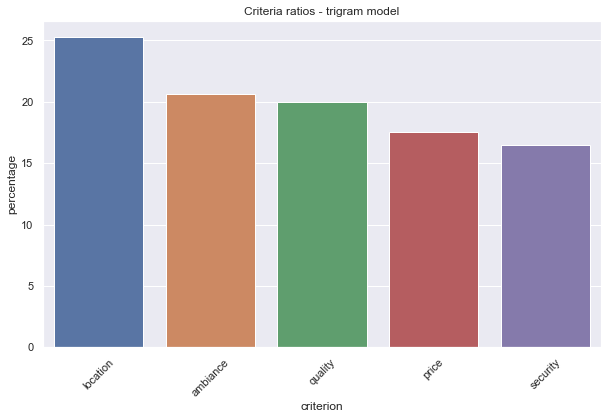

In [17]:
sb.barplot(data=tri_ratios, x='criterion', y='percentage').set(title='Criteria ratios - trigram model')
plt.xticks(rotation=45);

It can bee seen that the differences among ngram models are negligible in the last two criteria. Thus, we will take the average of the three models for conclusion.

#### Play with Word Cloud

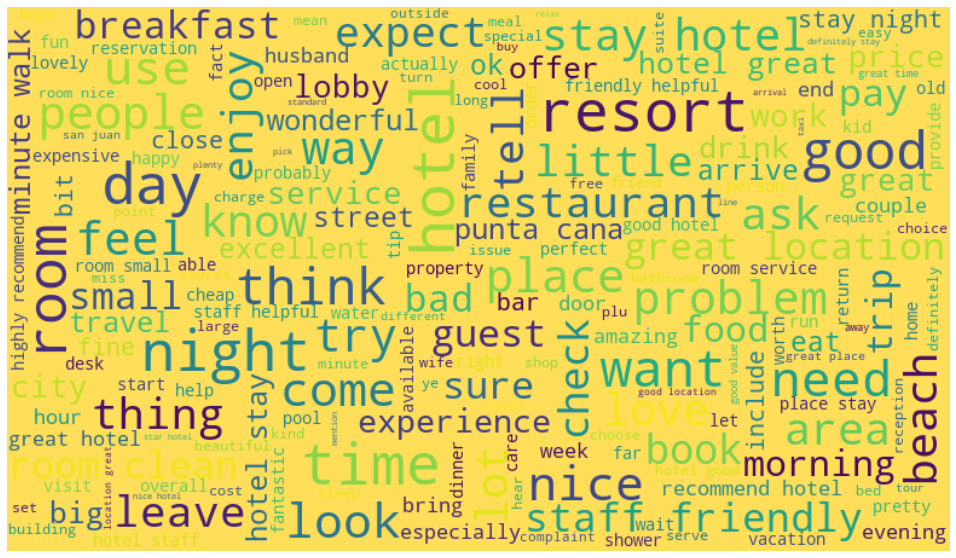

In [18]:
from wordcloud import WordCloud

# Generate a word cloud image of document
wordcloud = WordCloud(width=780, height=450, max_font_size=50,
                      background_color="#ffde59").generate(' '.join(reviews))

# Display the generated image:
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Conclusion

In [20]:
pd.options.display.float_format = '{:,.2f}'.format
# Return mean percentage of the three models
mean_df = pd.concat([uni_ratios, bi_ratios, tri_ratios], axis=0).groupby('criterion', as_index=False).mean().sort_values(by='percentage', ascending=False).reset_index(drop=True)
mean_df.index += 1
mean_df

,criterion,percentage
1,location,25.14
2,ambiance,22.38
3,quality,20.06
4,price,16.39
5,security,16.04
